# Data preparation

In [19]:
import pandas as pd

# Load your dataset
df = pd.read_csv('syntheticQDstructure.csv')
print(df.head())
print("Shape:", df.shape)

  core_composition ligand_composition  size (nm)  band_gap (eV)  \
0             InAs               TDPA        3.6           0.82   
1             ZnSe      Zinc stearate        3.8           3.07   
2             PbSe                MPA        6.9           1.06   
3              ZnS     Hexadecylamine        2.3           3.98   
4              InP                TOP        6.3           1.94   

   quantum_yield (%)  emission_maximum (nm) lattice_type  a (Å)  b (Å)  c (Å)  \
0                 64                    904  Zinc Blende   6.06   6.06   6.06   
1                 71                    544  Zinc Blende   5.67   5.67   5.67   
2                 32                    905    Rock Salt   6.12   6.12   6.12   
3                 45                    442        Cubic   5.41   5.41   5.41   
4                 70                    634  Zinc Blende   5.87   5.87   5.87   

   alpha (°)  beta (°)  gamma (°)  volume (Å³)  
0       90.0      90.0       90.0       222.55  
1       90.0

In [20]:
df_encoded = pd.get_dummies(df)
print(df_encoded.head())
print("Encoded Shape:", df_encoded.shape)

   size (nm)  band_gap (eV)  quantum_yield (%)  emission_maximum (nm)  a (Å)  \
0        3.6           0.82                 64                    904   6.06   
1        3.8           3.07                 71                    544   5.67   
2        6.9           1.06                 32                    905   6.12   
3        2.3           3.98                 45                    442   5.41   
4        6.3           1.94                 70                    634   5.87   

   b (Å)  c (Å)  alpha (°)  beta (°)  gamma (°)  ...  ligand_composition_OLA  \
0   6.06   6.06       90.0      90.0       90.0  ...                   False   
1   5.67   5.67       90.0      90.0       90.0  ...                   False   
2   6.12   6.12       90.0      90.0       90.0  ...                   False   
3   5.41   5.41       90.0      90.0       90.0  ...                   False   
4   5.87   5.87       90.0      90.0       90.0  ...                   False   

   ligand_composition_Oleic acid  liga

In [21]:
import torch

X_array = df_encoded.to_numpy(dtype='float32')
X_tensor = torch.tensor(X_array)

# Autoencoder

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# Define model, loss, optimizer
input_dim = X_tensor.shape[1]
latent_dim = 2  # small latent space for quantum training
model = Autoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

autoencoder_train_losses = []

# Train autoencoder
for epoch in range(50):
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        recon = model(batch[0])
        loss = criterion(recon, batch[0])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    avg_loss = total_loss / len(loader)
    autoencoder_train_losses.append(avg_loss)

# Save encoded data
with torch.no_grad():
    encoded_data = model.encoder(X_tensor).numpy()
    
print("Encoded Data Shape:", encoded_data.shape)
print("Encoded Data Sample:", encoded_data[:5])

Epoch 1, Loss: 58757.8311
Epoch 2, Loss: 55468.3018
Epoch 3, Loss: 52186.0215
Epoch 4, Loss: 28992.5449
Epoch 5, Loss: 13487.7493
Epoch 6, Loss: 6740.5137
Epoch 2, Loss: 55468.3018
Epoch 3, Loss: 52186.0215
Epoch 4, Loss: 28992.5449
Epoch 5, Loss: 13487.7493
Epoch 6, Loss: 6740.5137
Epoch 7, Loss: 3961.0416
Epoch 8, Loss: 2146.8596
Epoch 9, Loss: 3386.7479
Epoch 10, Loss: 2506.3658
Epoch 11, Loss: 1172.9151
Epoch 12, Loss: 1215.9531
Epoch 13, Loss: 1135.7588
Epoch 14, Loss: 1060.1193
Epoch 15, Loss: 908.5070
Epoch 16, Loss: 847.9487
Epoch 17, Loss: 799.3198
Epoch 18, Loss: 718.0852
Epoch 7, Loss: 3961.0416
Epoch 8, Loss: 2146.8596
Epoch 9, Loss: 3386.7479
Epoch 10, Loss: 2506.3658
Epoch 11, Loss: 1172.9151
Epoch 12, Loss: 1215.9531
Epoch 13, Loss: 1135.7588
Epoch 14, Loss: 1060.1193
Epoch 15, Loss: 908.5070
Epoch 16, Loss: 847.9487
Epoch 17, Loss: 799.3198
Epoch 18, Loss: 718.0852
Epoch 19, Loss: 725.4782
Epoch 20, Loss: 760.5771
Epoch 21, Loss: 713.2021
Epoch 22, Loss: 753.4362
Epoch 

# Data convertion into bitstrings

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
encoded_normalized = scaler.fit_transform(encoded_data)  # shape: (N, 2)


In [24]:
def float_to_bits(x, n_bits=4):
    """Convert a float in [0,1] to fixed-length binary string"""
    max_int = 2**n_bits - 1
    int_val = int(x * max_int)
    return format(int_val, f'0{n_bits}b')

n_bits = 4  # bits per latent dimension
bitstrings = []

for point in encoded_normalized:
    bits = ''.join(float_to_bits(x, n_bits) for x in point)
    bitstrings.append(bits)

print("Bitstrings Sample:", bitstrings[:5])

Bitstrings Sample: ['11001100', '00110011', '11001100', '00000000', '01010101']


# QCBM

In [25]:
from qiskit import QuantumCircuit
import numpy as np

def create_qcbm_circuit(num_qubits, parameters):
    qc = QuantumCircuit(num_qubits)
    idx = 0
    for i in range(num_qubits):
        qc.ry(parameters[idx], i)
        idx += 1
        qc.rz(parameters[idx], i)
        idx += 1
    for i in range(num_qubits - 1):
        qc.cx(i, i + 1)
    return qc


In [26]:
from qiskit.primitives import StatevectorSampler
from scipy.optimize import minimize
from collections import Counter

sampler = StatevectorSampler()
qcbm_train_losses = []

def compute_kl_divergence(p_data, p_model, epsilon=1e-8):
    # Ensure support match
    keys = set(p_data.keys()).union(set(p_model.keys()))
    return sum(
        p_data.get(k, 0) * np.log((p_data.get(k, epsilon) + epsilon) / (p_model.get(k, epsilon) + epsilon))
        for k in keys
    )

def evaluate_qcbm_loss(parameters, num_qubits, target_distribution):
    qc = create_qcbm_circuit(num_qubits, parameters)
    # Add measurements
    qc.measure_all()
    result = sampler.run([qc]).result()
    # In Qiskit 2.x, the result format is different
    pub_result = result[0]  # Get the first (and only) pub result
    bit_array = pub_result.data.meas
    counts = dict(bit_array.get_counts())
    # Normalize output - keys are already strings
    total_shots = sum(counts.values())
    model_distribution = {k: v / total_shots for k, v in counts.items()}
    loss = compute_kl_divergence(target_distribution, model_distribution)
    qcbm_train_losses.append(loss)
    return loss

def compute_data_distribution(binary_encoded_data):
    str_data = [''.join(str(bit) for bit in sample) for sample in binary_encoded_data]
    counts = Counter(str_data)
    total = sum(counts.values())
    return {k: v / total for k, v in counts.items()}

In [27]:
# Convert bitstrings to binary array format
binary_encoded_data = np.array([[int(bit) for bit in bitstring] for bitstring in bitstrings])

num_qubits = binary_encoded_data.shape[1]
num_parameters = 2 * num_qubits
initial_params = np.random.uniform(0, 2 * np.pi, num_parameters)

target_distribution = compute_data_distribution(binary_encoded_data)

result = minimize(
    evaluate_qcbm_loss,
    x0=initial_params,
    args=(num_qubits, target_distribution),
    method='COBYLA',
    options={'maxiter': 100}
)

trained_params = result.x
print(f"Optimization completed. Final loss: {result.fun}")
print(f"Number of qubits: {num_qubits}")
print(f"Target distribution (first 5 items): {dict(list(target_distribution.items())[:5])}")

Optimization completed. Final loss: 2.921717565257173
Number of qubits: 8
Target distribution (first 5 items): {'11001100': 0.15, '00110011': 0.12, '00000000': 0.11, '01010101': 0.05, '00010001': 0.13}


In [28]:
qc_trained = create_qcbm_circuit(num_qubits, trained_params)
qc_trained.measure_all()
result = sampler.run([qc_trained], shots=1000).result()

# Get the counts and convert to distribution
pub_result = result[0]
bit_array = pub_result.data.meas
counts = dict(bit_array.get_counts())
total_shots = sum(counts.values())
samples = {k: v / total_shots for k, v in counts.items()}

# Sort samples by probability
sorted_samples = sorted(samples.items(), key=lambda x: x[1], reverse=True)
top_samples = [k for k, _ in sorted_samples[:10]]
decoded_inputs = [np.array([int(bit) for bit in s]) for s in top_samples]

print("Top 10 most probable samples:")
for i, (sample, prob) in enumerate(sorted_samples[:10]):
    print(f"{i+1}. {sample}: {prob:.4f}")

Top 10 most probable samples:
1. 00111100: 0.0480
2. 01000011: 0.0410
3. 11000011: 0.0390
4. 11011100: 0.0270
5. 00100011: 0.0240
6. 10111100: 0.0240
7. 00000011: 0.0180
8. 11111100: 0.0180
9. 10100011: 0.0180
10. 00111101: 0.0160


# Data convertion back into the original format

In [29]:
# Convert bit strings back to 2D latent space format
def bits_to_float(bits, n_bits=4):
    """Convert binary string to float in [0,1]"""
    max_int = 2**n_bits - 1
    int_val = int(bits, 2)
    return int_val / max_int

# Convert the top samples back to 2D latent vectors
latent_vectors = []
for sample in top_samples:
    # Split the 8-bit string into two 4-bit parts
    bits_dim1 = sample[:4]  # First 4 bits
    bits_dim2 = sample[4:]  # Last 4 bits
    
    # Convert back to floats in [0,1]
    float_dim1 = bits_to_float(bits_dim1, n_bits)
    float_dim2 = bits_to_float(bits_dim2, n_bits)
    
    latent_vectors.append([float_dim1, float_dim2])

# Convert to tensor with proper scaling (inverse of normalization)
latent_tensor = torch.tensor(latent_vectors, dtype=torch.float32)
# Scale back to original latent space range using the fitted scaler
latent_scaled = scaler.inverse_transform(latent_tensor.numpy())
latent_scaled_tensor = torch.tensor(latent_scaled, dtype=torch.float32)

model.decoder.eval()  # Set to eval mode (no dropout/batchnorm)

with torch.no_grad():
    reconstructed_outputs = model.decoder(latent_scaled_tensor)
    
synthetic_results = reconstructed_outputs.numpy()
print("Synthetic results shape:", synthetic_results.shape)
print("Synthetic results sample:", synthetic_results[:3])
print("Latent vectors shape:", latent_scaled_tensor.shape)
print("Latent vectors sample:", latent_scaled_tensor[:3])

Synthetic results shape: (10, 34)
Synthetic results sample: [[-2.29461145e+00 -4.48974085e+00  3.14428673e+01  6.39364807e+02
  -7.04326200e+00  6.47582054e+00  2.02504196e+01  6.86769028e+01
   8.05804367e+01  8.13445663e+01  1.66824860e+02 -3.05926025e-01
  -8.18888378e+00 -1.83299236e+01 -2.38988733e+00  6.20908403e+00
   4.53551245e+00  1.76668377e+01 -1.22145929e+01  2.73442864e+00
  -5.41428387e-01  7.18663931e+00 -8.67450333e+00  7.77716827e+00
  -1.43143682e+01 -4.59695911e+00 -1.56959820e+01  7.68069124e+00
   1.41421900e+01  6.83202839e+00 -6.80007815e-01 -1.06901808e+01
   2.25420758e-01  3.34535050e+00]
 [-5.22381663e-01  2.17720628e+00  4.05453987e+01  5.99363770e+02
   6.02673388e+00  5.20370674e+00  2.79196239e+00  7.24630432e+01
   7.14123917e+01  7.45398026e+01  1.60460617e+02  8.42328191e-01
  -1.08192861e-02  1.34376836e+00  2.49356675e+00 -6.63155258e-01
  -6.47132218e-01 -1.65875363e+00  1.70763254e+00 -1.49824274e+00
  -3.24335337e-01  4.85418707e-01  7.69388437e-

In [30]:

categorical_cols = ['core_composition', 'ligand_composition', 'lattice_type']

dummy_columns = [col for col in df_encoded.columns if any(col.startswith(cat + '_') for cat in categorical_cols)]
synthetic_df = pd.DataFrame(synthetic_results, columns=df_encoded.columns)
for col in categorical_cols:
    # Extract relevant dummy columns
    dummy_subset = synthetic_df[[c for c in synthetic_df.columns if c.startswith(col + '_')]]
    
    # Find argmax (i.e., the "1") to get back the original category
    synthetic_df[col] = dummy_subset.idxmax(axis=1).str.replace(col + '_', '')

    # Drop the dummy columns
    synthetic_df.drop(columns=dummy_subset.columns, inplace=True)
    
column_order = df.columns.tolist()
synthetic_df = synthetic_df.reindex(columns=column_order)

print("Synthetic DataFrame head:")
print(synthetic_df.head())

Synthetic DataFrame head:
  core_composition ligand_composition  size (nm)  band_gap (eV)  \
0             PbSe               TOPO  -2.294611      -4.489741   
1             InAs               TDPA  -0.522382       2.177206   
2              ZnS               TDPA   2.988645       8.926115   
3             InAs                TOP  -1.263408       2.617404   
4             PbSe               TOPO  -1.400131       0.489980   

   quantum_yield (%)  emission_maximum (nm) lattice_type      a (Å)     b (Å)  \
0          31.442867             639.364807  Zinc Blende  -7.043262  6.475821   
1          40.545399             599.363770    Hexagonal   6.026734  5.203707   
2          59.470123             809.096619    Hexagonal  20.933393  6.184979   
3          61.064495             909.892029  Zinc Blende   8.366916  7.631989   
4          35.814220             546.930542  Zinc Blende   2.300075  4.958383   

       c (Å)   alpha (°)    beta (°)   gamma (°)  volume (Å³)  
0  20.250420   68.67

In [31]:
synthetic_df.to_csv("synthetic_results.csv", index=False)

# Plots

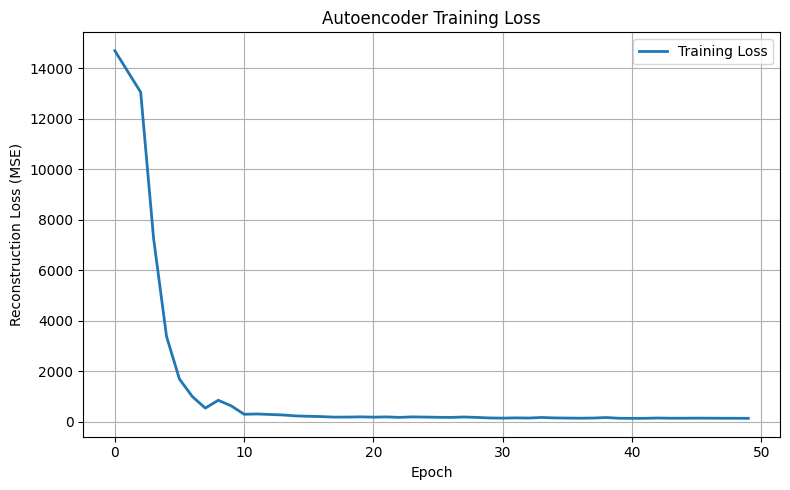

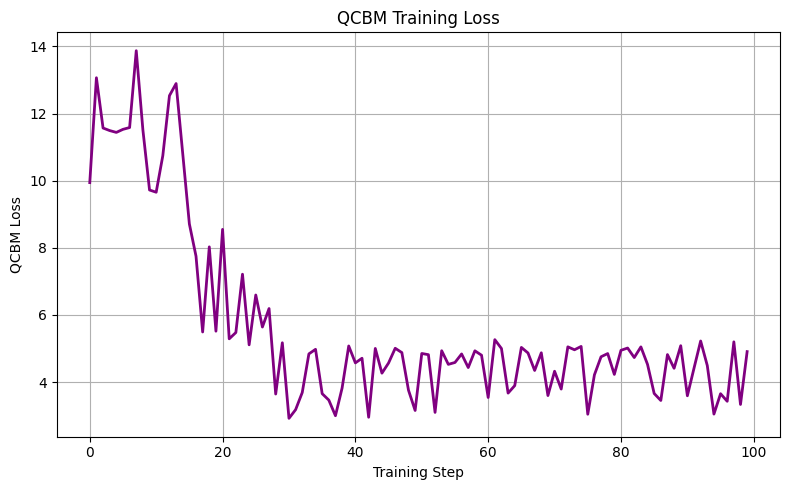

In [32]:
import matplotlib.pyplot as plt

def plot_autoencoder_loss(train_losses, val_losses=None):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Training Loss", linewidth=2)
    if val_losses is not None:
        plt.plot(val_losses, label="Validation Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Reconstruction Loss (MSE)")
    plt.title("Autoencoder Training Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.show()
    plt.savefig("autoencoder_training_loss.png")

def plot_qcbm_training_loss(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(losses, color='purple', linewidth=2)
    plt.xlabel("Training Step")
    plt.ylabel("QCBM Loss")
    plt.title("QCBM Training Loss")
    plt.grid(True)
    plt.tight_layout()
    #plt.show()
    plt.savefig("qcbm_training_loss.png")

plot_autoencoder_loss(autoencoder_train_losses)
plot_qcbm_training_loss(qcbm_train_losses)

In [33]:
# Fixed novelty score computation
from scipy.spatial.distance import cdist
import numpy as np

def compute_novelty_scores(generated_latents, train_latents):
    """
    For each generated latent vector, compute the minimum distance to any train latent vector.
    """
    distances = cdist(generated_latents, train_latents, metric='euclidean')
    novelty_scores = np.min(distances, axis=1)  # Closest training example
    return novelty_scores

# Use detach().numpy() to convert tensor to numpy array without gradients
with torch.no_grad():
    train_latents = model.encoder(X_tensor).detach().numpy()

novelty_scores = compute_novelty_scores(latent_scaled, train_latents)
print(f"Novelty scores computed for {len(novelty_scores)} generated samples")
print(f"Mean novelty score: {np.mean(novelty_scores):.4f}")
print(f"Min novelty score: {np.min(novelty_scores):.4f}")
print(f"Max novelty score: {np.max(novelty_scores):.4f}")

Novelty scores computed for 10 generated samples
Mean novelty score: 73.7194
Min novelty score: 14.8066
Max novelty score: 153.0052


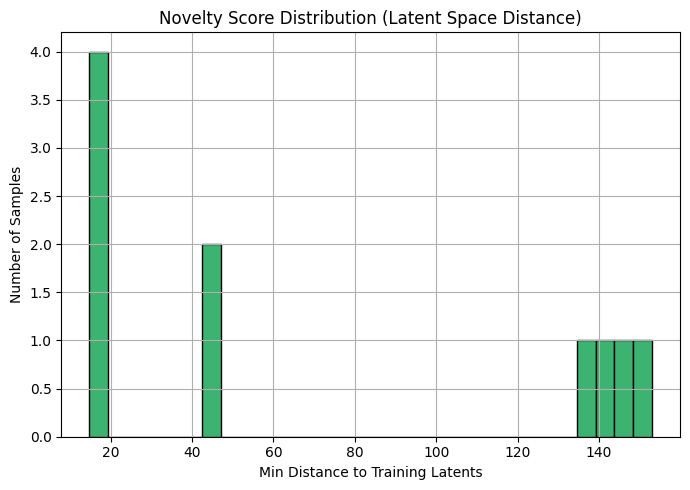

In [36]:
import matplotlib.pyplot as plt

def plot_novelty_scores(novelty_scores):
    plt.figure(figsize=(7, 5))
    plt.hist(novelty_scores, bins=30, color='mediumseagreen', edgecolor='black')
    plt.title("Novelty Score Distribution (Latent Space Distance)")
    plt.xlabel("Min Distance to Training Latents")
    plt.ylabel("Number of Samples")
    plt.grid(True)
    plt.tight_layout()
    #plt.show()
    plt.savefig("novelty_scores_distribution.png")

plot_novelty_scores(novelty_scores)


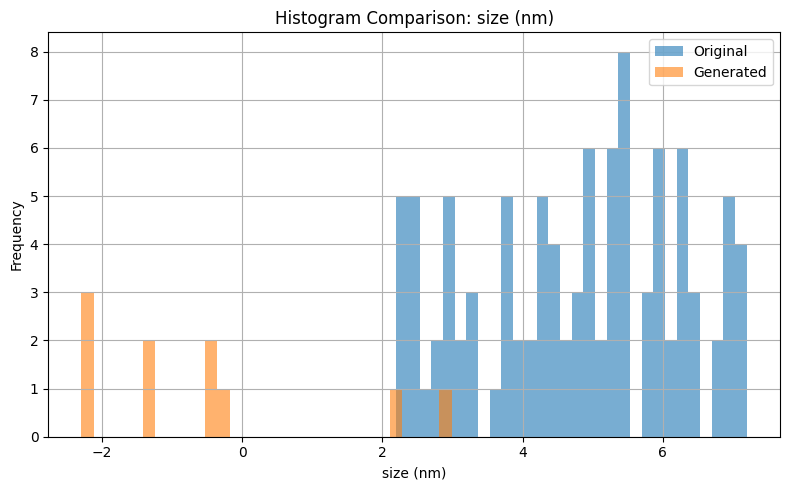

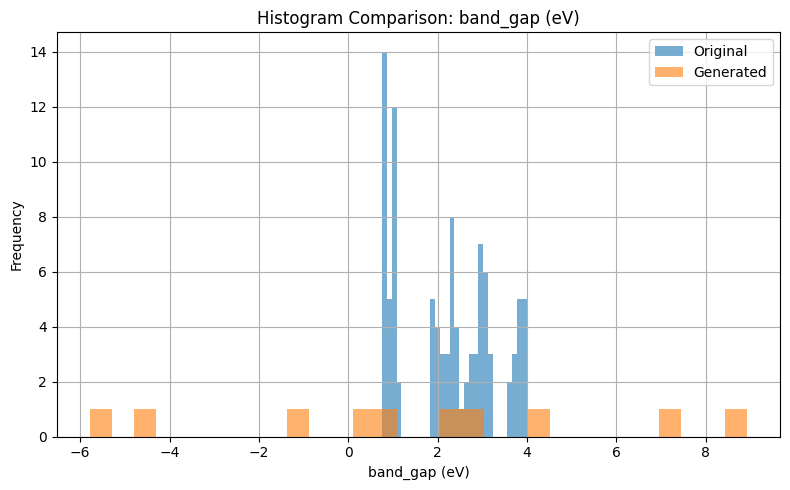

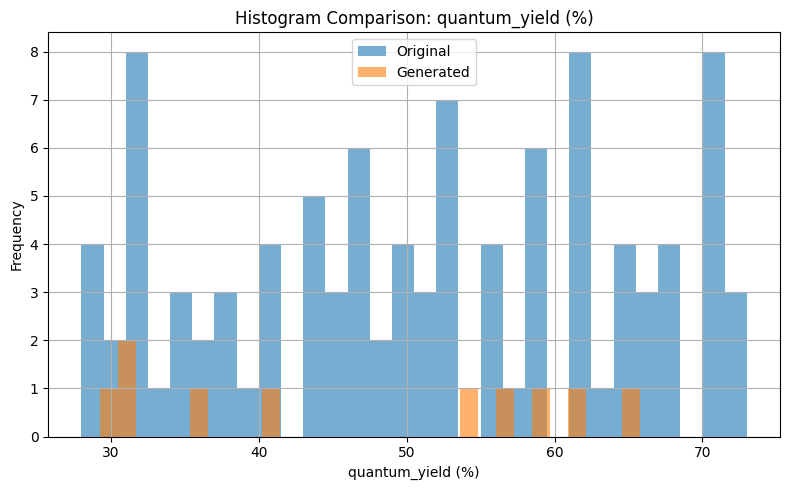

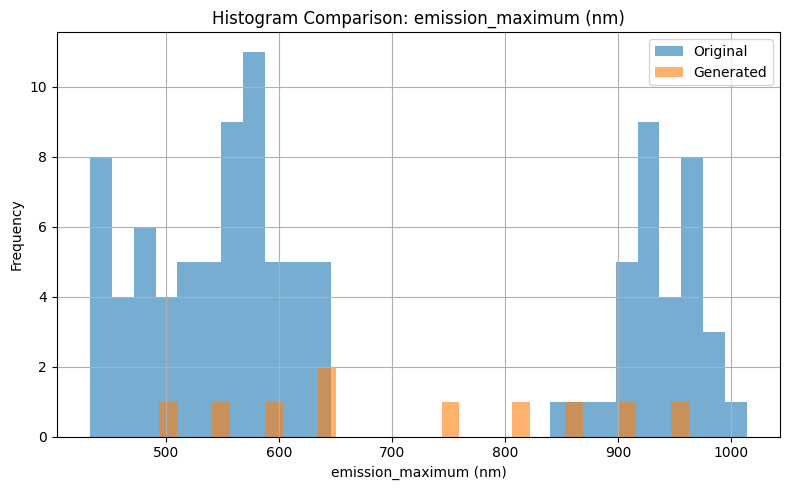

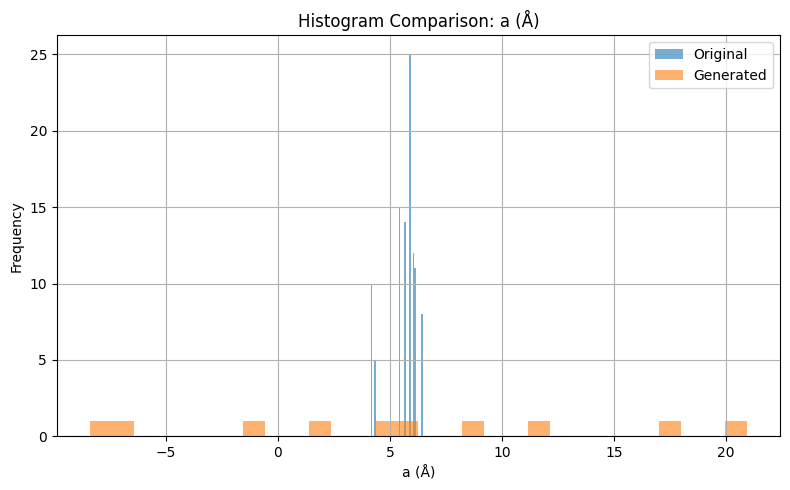

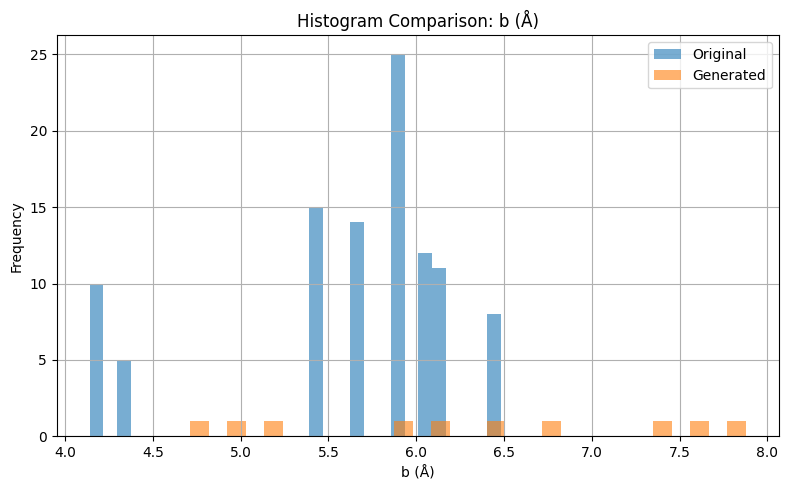

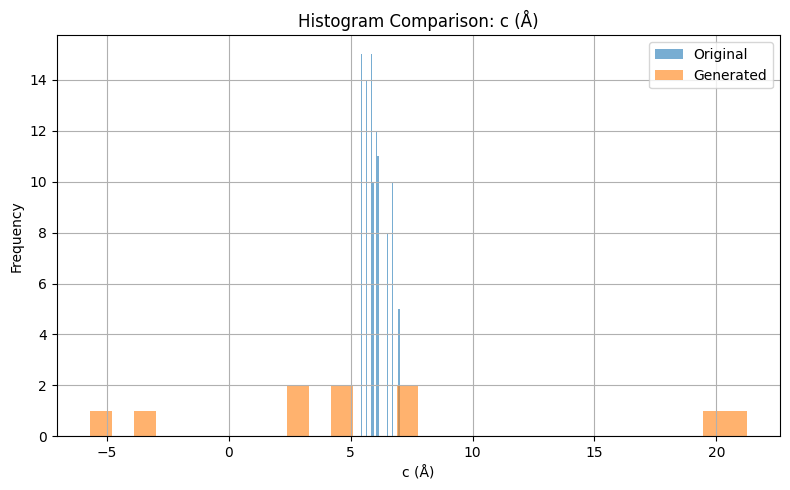

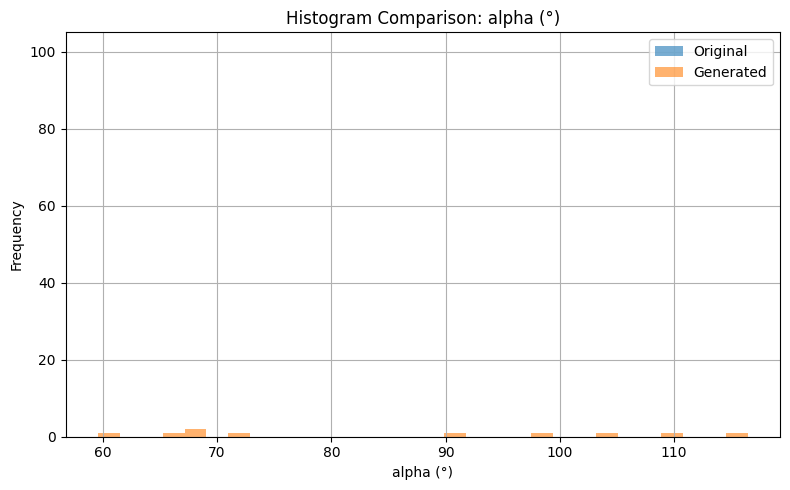

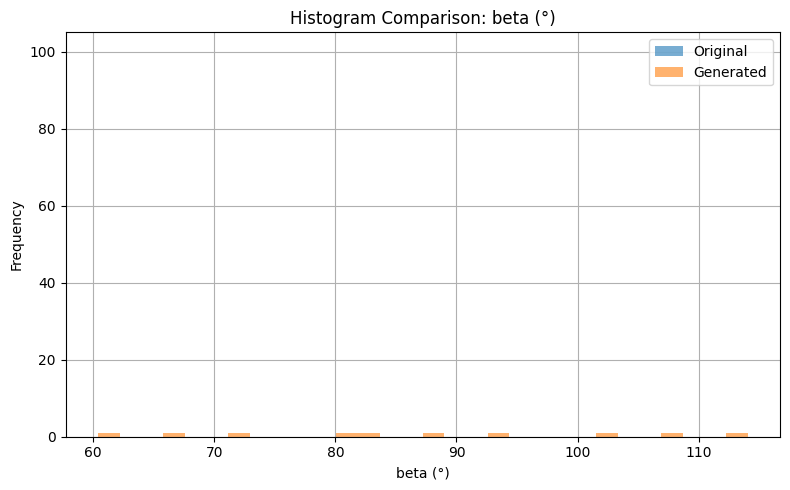

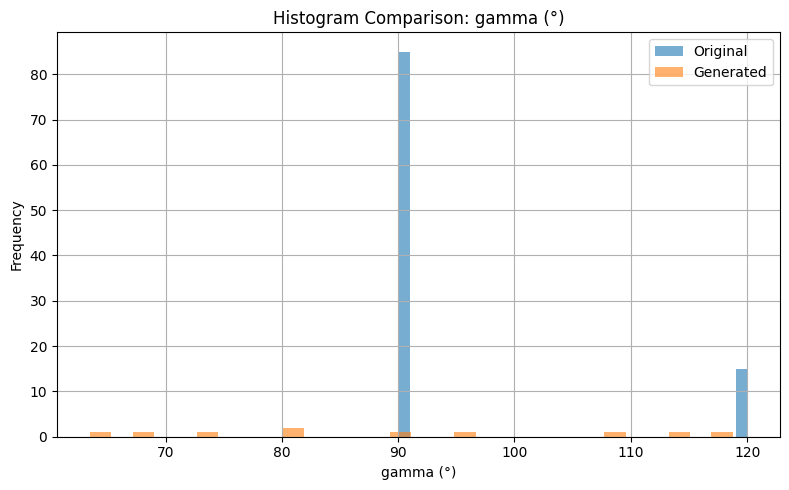

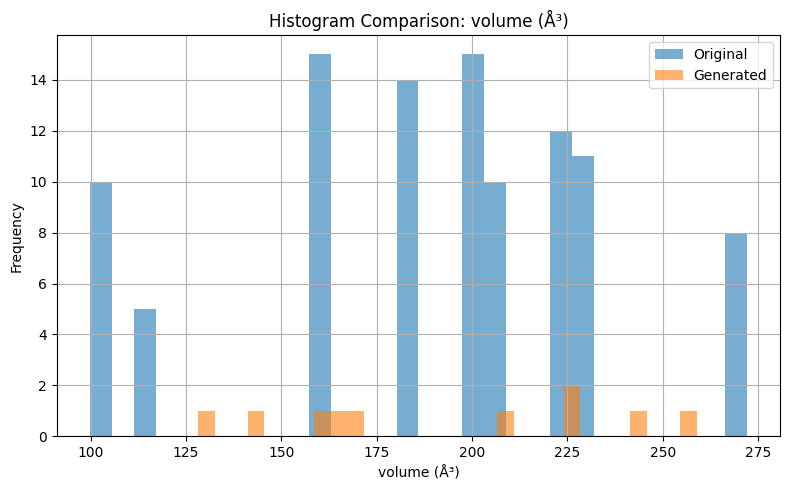

In [35]:
def compare_histograms(original, generated, column):
    plt.figure(figsize=(8, 5))
    plt.hist(original[column], bins=30, alpha=0.6, label="Original")
    plt.hist(generated[column], bins=30, alpha=0.6, label="Generated")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.title(f"Histogram Comparison: {column}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.show()
    plt.savefig(f"histogram_comparison_{column}.png")
    
for column in df.columns:
    if column not in categorical_cols:  # Skip categorical columns
        compare_histograms(df, synthetic_df, column)    